In [1]:
%matplotlib widget

# ERT simulation

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import root_mean_squared_error
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert

### Define geometry

In [3]:
world = mt.createWorld(start=[0, 0], end=[39, -6], 
                       worldMarker=True)

xz = np.load('models/boundary.npy')

line = mt.createPolygon(xz, marker=1)

geom = world + line

(<Axes: >, None)

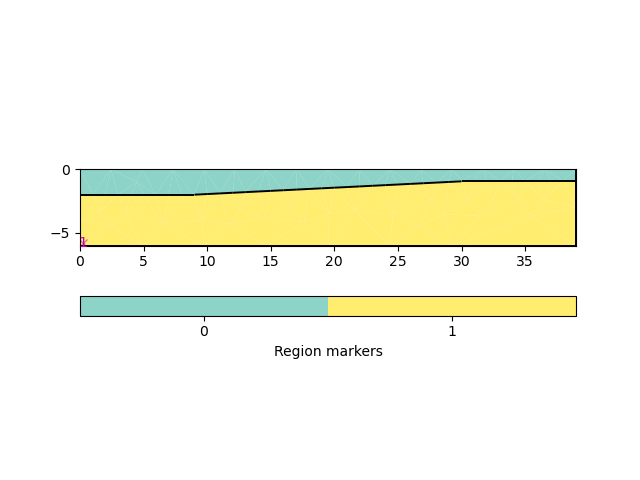

In [4]:
pg.show(geom)

In [5]:
scheme = ert.createData(elecs=np.linspace(start=0, stop=36, num=72, endpoint=False),
                           schemeName='dd')

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7fae01511090>)

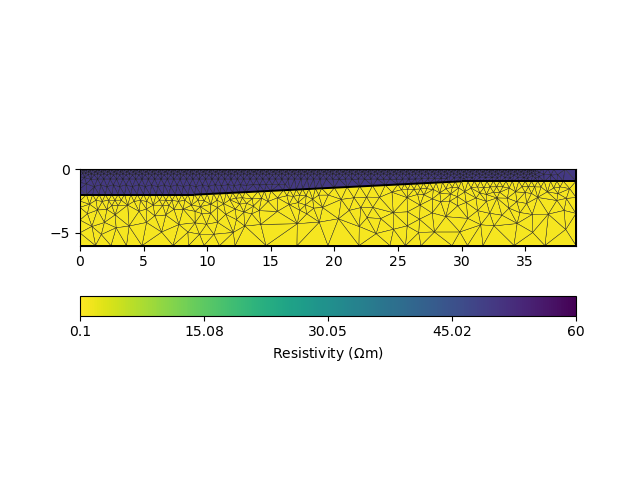

In [6]:
for p in scheme.sensors():
    geom.createNode(p)
    geom.createNode(p - [0, 0.1])

# Create a mesh for the finite element modelling with appropriate mesh quality.
mesh = mt.createMesh(geom, quality=32)

# Create a map to set resistivity values in the appropriate regions
# [[regionNumber, resistivity], [regionNumber, resistivity], [...]
rhomap = [[0, 50],
          [1, 0.83],]

# Take a look at the mesh and the resistivity distribution
pg.show(mesh, data=rhomap, label=pg.unit('res'), showMesh=True, cMin=0.1, cMax=60, cMap='viridis_r',
       norm='log', )

### Simulate data

In [7]:
data = ert.simulate(mesh, scheme=scheme, res=rhomap, noiseLevel=1,
                    noiseAbs=1e-6, seed=1337)

pg.info(np.linalg.norm(data['err']), np.linalg.norm(data['rhoa']))
pg.info('Simulated data', data)
pg.info('The data contains:', data.dataMap().keys())

pg.info('Simulated rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))
pg.info('Selected data noise %(min/max)', min(data['err'])*100, max(data['err'])*100)

21/04/24 - 19:16:11 - pyGIMLi - INFO - Data error estimate (min:max)  0.010000184537695129 : 0.9839902113644825
21/04/24 - 19:16:11 - pyGIMLi - INFO - 6.671883273092878 995.1707302861009
21/04/24 - 19:16:11 - pyGIMLi - INFO - Simulated data Data: Sensors: 72 data: 2415, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'rhoa', 'valid']
21/04/24 - 19:16:11 - pyGIMLi - INFO - The data contains: ['a', 'b', 'err', 'i', 'ip', 'iperr', 'k', 'm', 'n', 'r', 'rhoa', 'u', 'valid']
21/04/24 - 19:16:11 - pyGIMLi - INFO - Simulated rhoa (min/max) -0.011006605884056782 52.61478190731291
21/04/24 - 19:16:11 - pyGIMLi - INFO - Selected data noise %(min/max) 1.000018453769513 98.39902113644825


relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100ModellingBase::setMesh() copying new mesh ... Found datafile: 72 electrodes
Found: 72 free-electrodes

rMin = 0.25, rMax = 71
NGauLeg + NGauLag for inverse Fouriertransformation: 14 + 4
Found non-Neumann domain
0.0240749 s
FOP updating mesh dependencies ... 4e-06 s
Calculating response for model: min = 0.83 max = 50
Allocating memory for primary potential...... 0.0092194

No primary potential for secondary field calculation. Calculating analytically...
Forward: time: 0.267586s
Response: min = 0.492064 max = 51.3739 mean = 11.0386
Reciprocity rms(modelReciprocity) 35.9749%, max: 86.8282%


21/04/24 - 19:16:11 - pyGIMLi - INFO - Filtered rhoa (min/max) 0.021042627890924124 52.61478190731291


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7fadf9215850>)

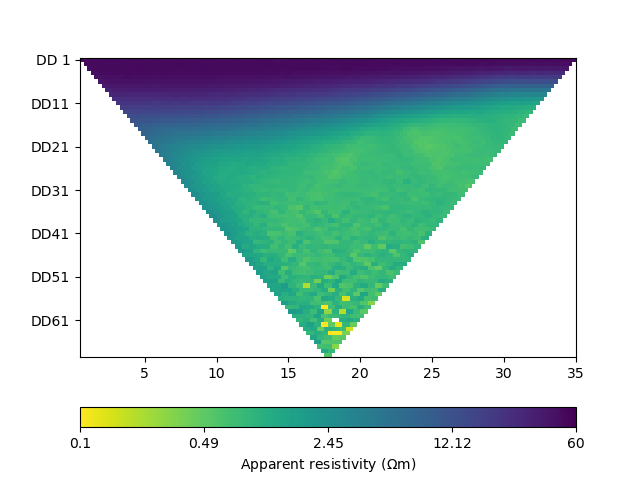

In [8]:
data.remove(data['rhoa'] < 0)
pg.info('Filtered rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))

# You can save the data for further use
data.save('data/ERTLine_f.dat')

# You can take a look at the data
ert.show(data, cMin=0.1, cMax=60, cMap='viridis_r')

### Invert 

In [9]:
mgr = ert.ERTManager('data/ERTLine_f.dat')

In [10]:
inv = mgr.invert(lam=20, verbose=False, limits=[0.1, 100])
#np.testing.assert_approx_equal(mgr.inv.chi2(), 0.7, significant=1)

21/04/24 - 19:16:24 - pyGIMLi - INFO - Found 2 regions.
21/04/24 - 19:16:24 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
21/04/24 - 19:16:24 - pyGIMLi - INFO - Found 2 regions.
21/04/24 - 19:16:24 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
21/04/24 - 19:16:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
21/04/24 - 19:16:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
21/04/24 - 19:16:24 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 3214 Cells: 6052 Boundaries: 4726
21/04/24 - 19:16:24 - pyGIMLi - INFO - Use median(data values)=1.35159410778504
21/04/24 - 19:16:24 - pyGIMLi - INFO - Created startmodel from forward operator: 1212, min/max=1.351594/1.351594
IOStream.flush timed out


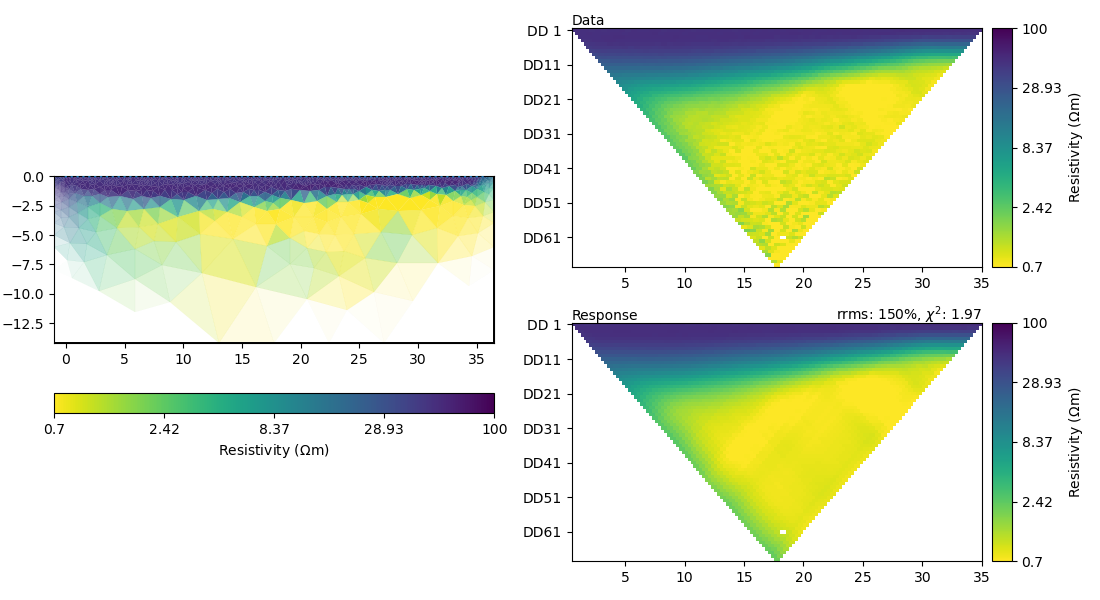

In [12]:
mgr.showResultAndFit(cMin=0.7, cMax=100, cMap='viridis_r')
meshPD = pg.Mesh(mgr.paraDomain) # Save copy of para mesh for plotting later

Text(0.5, 1.0, 'True Model')

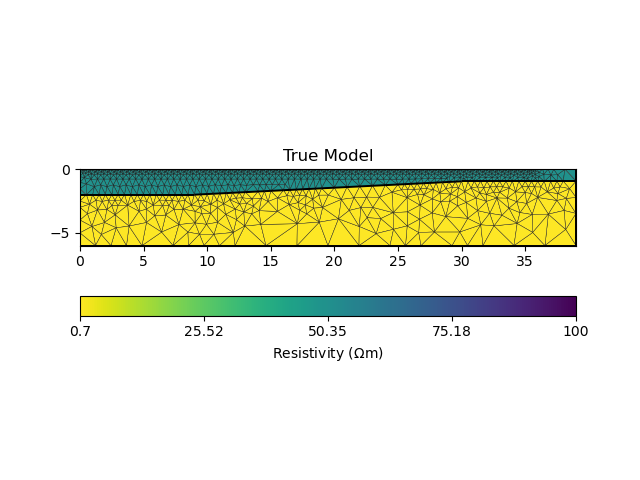

In [13]:
fig, ax = plt.subplots()
pg.show(mesh, data=rhomap, label=pg.unit('res'), 
        showMesh=True, cMin=0.7, cMax=100, cMap='viridis_r', ax=ax)
ax.set_ylim([-6,0])
#ax.set_xlim([-72,72])
ax.set_title('True Model')

Text(0, -5, 'RMSE: 1.97')

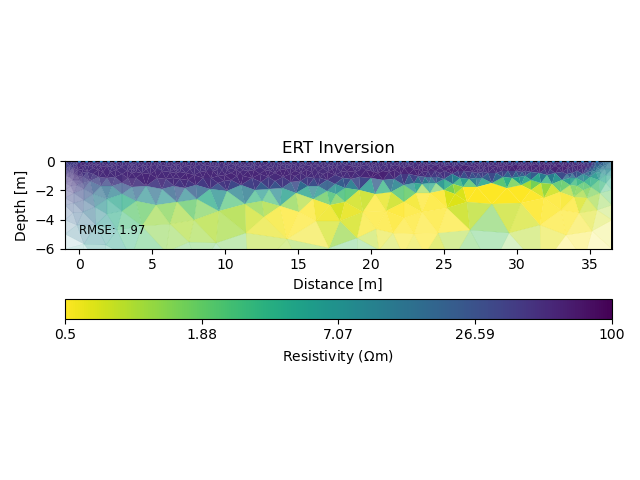

In [22]:
fig, ax = plt.subplots()

mgr.showModel(cMin=0.5, cMax=100, cMap='viridis_r', elecs=True, ax=ax, zMax=6, )
ax.set_ylim([-6,0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Distance [m]')
plt.tight_layout()
ax.set_title('ERT Inversion')
#rmse = root_mean_squared_error(models.ravel(), models_est.ravel())
ax.text(0, -5, 'RMSE: ' + "{:1.2f}".format(1.97), fontsize='small')

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7f8f15fcaa50>)

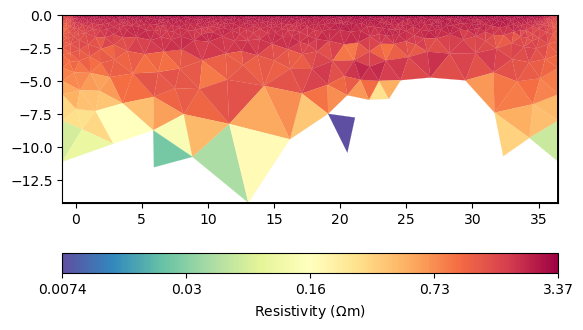

In [14]:
fig, ax = plt.subplots()
mgr.fop.drawModel(ax, mgr.coverage())

In [44]:
mgr.model

1212 [49.691642501708266,...,0.7201726708095854]

array([<Axes: >, <Axes: >], dtype=object)

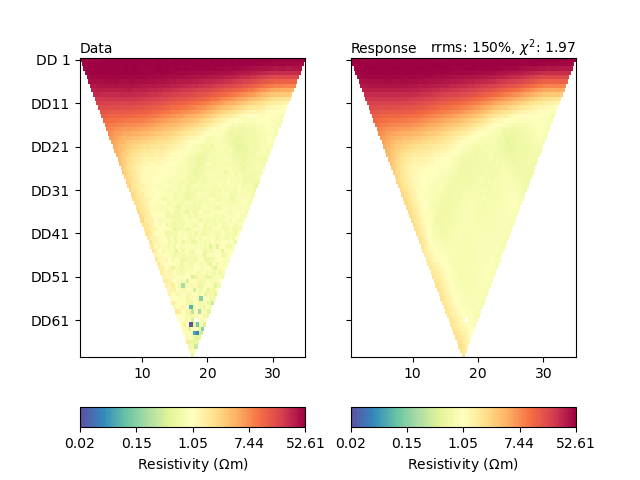

In [15]:
mgr.showFit()